In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/a_yoshino/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
exi_train = pd.read_csv('../input/train.csv')
exi_test = pd.read_csv('../input/test.csv')

In [3]:
train = pd.DataFrame([])
test = pd.DataFrame([])
for i in range(0, 200):
    train[f'var_0_{i}'] = exi_train['var_0'] + exi_train[f'var_{i}']
for i in range(0, 200):
    test[f'var_0_{i}'] = exi_test['var_0'] + exi_test[f'var_{i}']

In [4]:
# positive_count_train = train['target'].sum()

In [5]:
# rus = RandomUnderSampler(ratio={0:positive_count_train*3, 1:positive_count_train}, random_state=0)
# X_train_resampled, y_train_resampled = rus.fit_sample(train[train.columns[2:]], train['target'])

In [6]:
features = train.columns
y_train_df = pd.DataFrame(exi_train['target'], columns=['target'])
# train = pd.DataFrame(X_train_resampled, columns=features)

In [7]:
# colors = ['darkseagreen','lightcoral']
# plt.figure(figsize=(6,6))
# plt.pie(y_train_df['target'].value_counts(), explode=(0, 0.25), labels= ["0", "1"],
#         startangle=45, autopct='%1.1f%%', colors=colors)
# plt.axis('equal')
# plt.show()

In [8]:
target = y_train_df['target']

In [9]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [10]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.855849	valid_1's auc: 0.827504
[2000]	training's auc: 0.880316	valid_1's auc: 0.848061
[3000]	training's auc: 0.892682	valid_1's auc: 0.856203
[4000]	training's auc: 0.901581	valid_1's auc: 0.861063
[5000]	training's auc: 0.909125	valid_1's auc: 0.86439
[6000]	training's auc: 0.915321	valid_1's auc: 0.866663
[7000]	training's auc: 0.921088	valid_1's auc: 0.868636
[8000]	training's auc: 0.926319	valid_1's auc: 0.870146
[9000]	training's auc: 0.931048	valid_1's auc: 0.87142
[10000]	training's auc: 0.935357	valid_1's auc: 0.872165
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.935357	valid_1's auc: 0.872165
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.855793	valid_1's auc: 0.824055
[2000]	training's auc: 0.880447	valid_1's auc: 0.843598
[3000]	training's auc: 0.892718	valid_1's auc: 0.852934
[4000]	training's auc: 0.9

NameError: name 'ntarget' is not defined

In [11]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.87293 


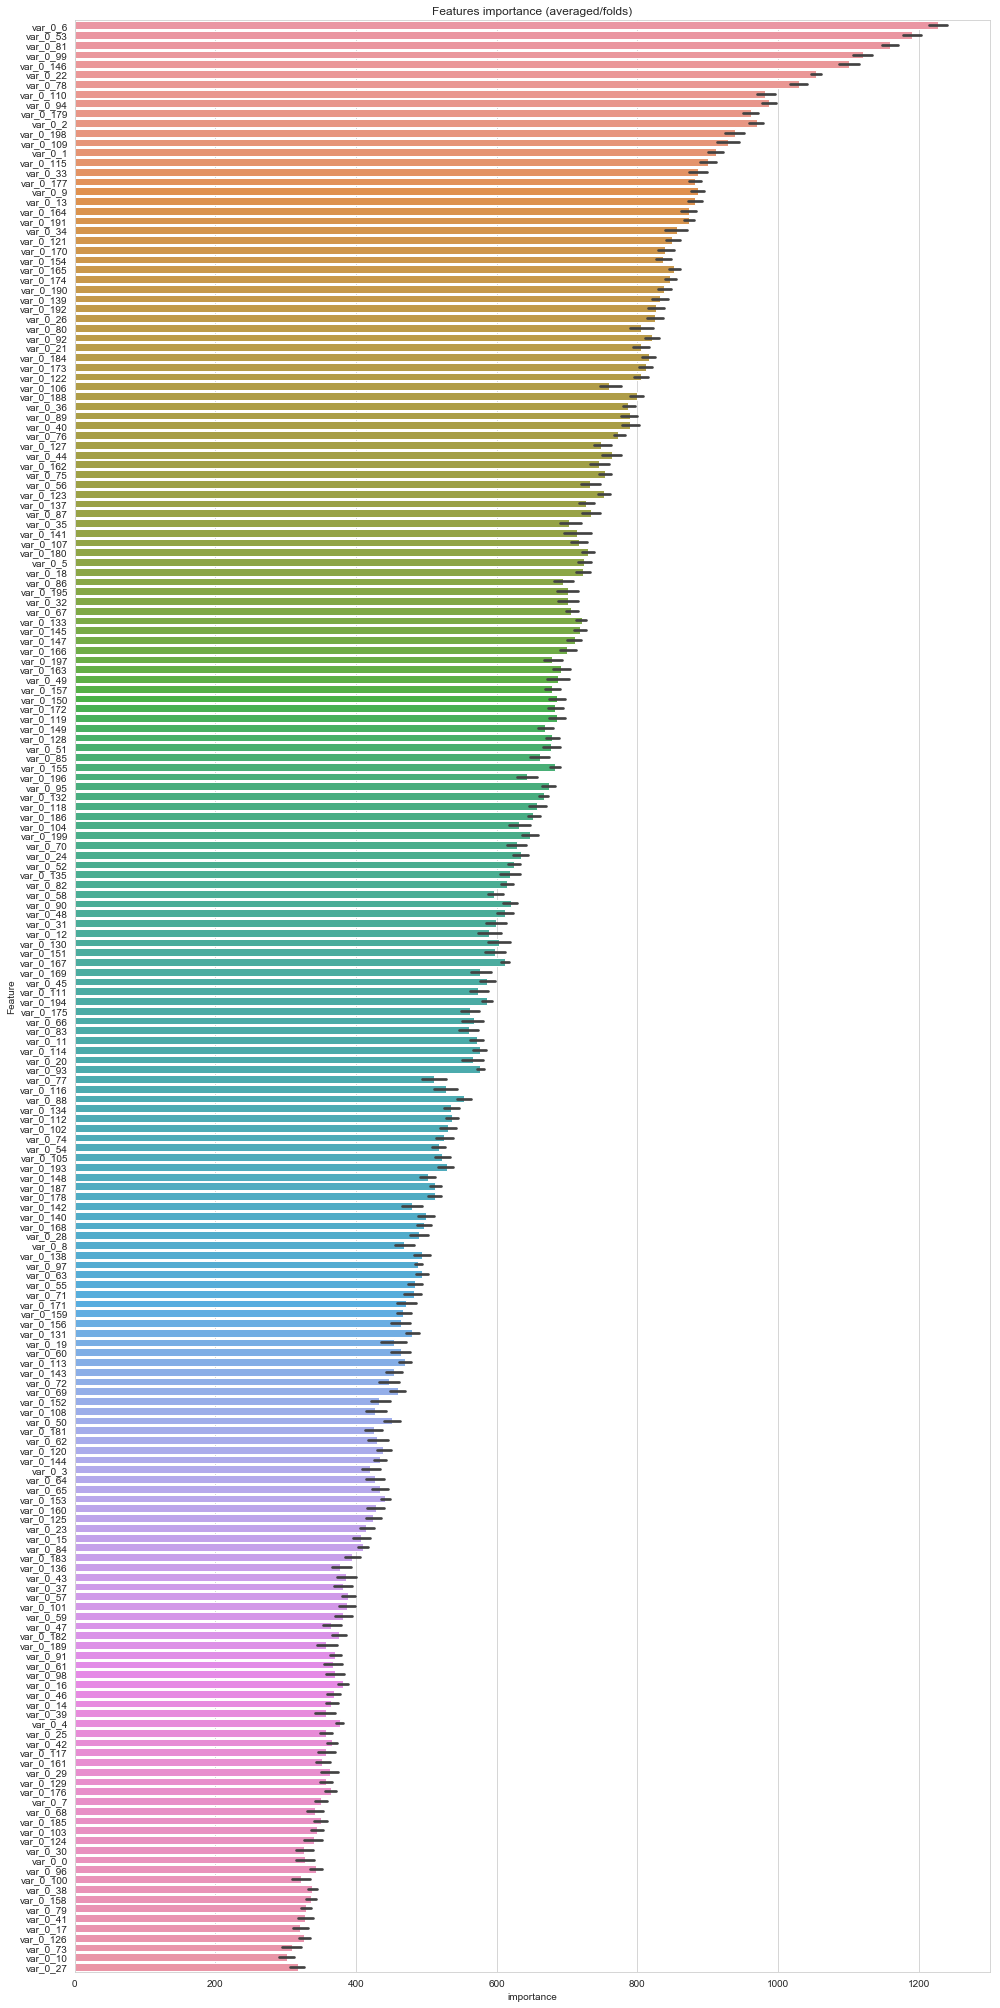

In [19]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:600].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [21]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": exi_test.ID_code.values})
sub["target"]=predictions
sub.to_csv(f"submission_{score}.csv", index=False)